In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
import pandas as pd
import copy

from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset, ConcatDataset
from rdkit import Chem
from conf_ensemble_dataset_in_memory import ConfEnsembleDataset
from rdkit.Chem import AllChem #needed for rdForceFieldHelpers
from collections import defaultdict
from litschnet import LitSchNet
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from rmsd_predictor_evaluator import RMSDPredictorEvaluator
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

# Data preparation

In [3]:
data_dir = 'data/'

In [4]:
platinum_dataset = ConfEnsembleDataset(dataset='platinum', loaded_chunk=0)

Grouping data by smiles


  0%|                                                  | 0/4000 [00:00<?, ?it/s]

Starting evaluation


100%|███████████████████████████████████████| 4000/4000 [01:15<00:00, 52.65it/s]


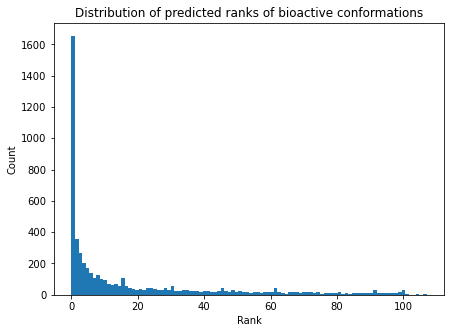

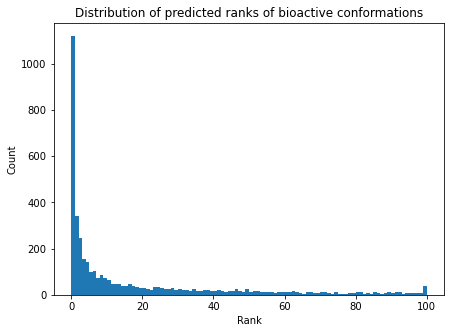

In [6]:
iteration = 0
experiment_name = f'scaffold_split_{iteration}_new'
if experiment_name in os.listdir('lightning_logs') :
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
        
evaluator = RMSDPredictorEvaluator(model=litschnet, experiment_name=experiment_name)
evaluator.evaluate(platinum_dataset)
#evaluator.evaluation_report(experiment_name=experiment_name + '_platinum')

In [7]:
evaluator.dataset_results

{'bioactive_accuracy': {'q1_all_bioactive': 1.0,
  'median_all_bioactive': 5.0,
  'q3_all_bioactive': 26.0,
  'q1_min_bioactive': 0.0,
  'median_min_bioactive': 4.0,
  'q3_min_bioactive': 24.0,
  'mean_top1_accuracy': 0.28,
  'mean_topN_accuracy': 0.2817824134199134},
 'regression': {'Micro': {'rmse_all': 0.5768849,
   'rmse_gen': 0.7124936,
   'rmse_bio': 1.0456016,
   'r2_all': 0.49879345602996594,
   'r2_gen': 0.1807974643106427,
   'pearson_all': 0.7221129137271769,
   'pearson_gen': 0.5435909643923114,
   'spearman_all': 0.7007222142552835,
   'spearman_gen': 0.5357226717663893},
  'Macro': {'rmse_all': 0.50281596,
   'rmse_gen': 0.47366694,
   'rmse_bio': 1.0357779,
   'r2_all': -95.65871819969941,
   'r2_gen': -100.51900137910087,
   'pearson_all': 0.3522278918305643,
   'pearson_gen': 0.33703734114776623,
   'spearman_all': 0.32735938355389627,
   'spearman_gen': 0.3195984392255301}},
 'ranking': {'random': {'bedroc': 0.09903305832830592,
   'ef': 0.8403740983772408},
  'energy

In [ ]:
from sklearn.metrics import r2_score
r2_score(all_generated_targets, all_generated_preds)

In [ ]:
from sklearn.metrics import r2_score
r2_score(all_targets, all_preds)

In [ ]:
evaluator.dataset_results['regression'] = {}
            
all_targets = []
all_preds = []
all_bioactive_preds = []
all_generated_targets = []
all_generated_preds = []
for smiles, results_d in evaluator.conf_results.items() :
    all_targets.extend([target for target in results_d['targets']])
    all_preds.extend([target for target in results_d['preds']])
    all_bioactive_preds.extend([target for target in results_d['bioactive_preds']])
    if 'generated_targets' in results_d :
        all_generated_targets.extend([target for target in results_d['generated_targets']])
        all_generated_preds.extend([pred for pred in results_d['generated_preds']])

#evaluator.plot_regression(all_targets, all_preds)

In [ ]:
len(all_preds)

In [ ]:
len(all_targets)

In [ ]:
conf_results = evaluator.conf_results
mol_results = evaluator.mol_results

In [ ]:
conf_results['COc1ccc(-c2cn(C)c(=O)c3cc(C(=O)NC4CCS(=O)(=O)CC4)sc23)cc1OC']

In [ ]:
mol_results['COc1ccc(-c2cn(C)c(=O)c3cc(C(=O)NC4CCS(=O)(=O)CC4)sc23)cc1OC']